In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [11]:
taxi_data = pd.read_csv('yellow_tripdata_2020-01.csv')

In [12]:
taxi_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2020-01-01 00:28:15,2020-01-01 00:33:03,1.0,1.2,1.0,N,238,239,1.0,6.0,3.0,0.5,1.47,0.0,0.3,11.27,2.5
1,1.0,2020-01-01 00:35:39,2020-01-01 00:43:04,1.0,1.2,1.0,N,239,238,1.0,7.0,3.0,0.5,1.50,0.0,0.3,12.30,2.5
2,1.0,2020-01-01 00:47:41,2020-01-01 00:53:52,1.0,0.6,1.0,N,238,238,1.0,6.0,3.0,0.5,1.00,0.0,0.3,10.80,2.5
3,1.0,2020-01-01 00:55:23,2020-01-01 01:00:14,1.0,0.8,1.0,N,238,151,1.0,5.5,0.5,0.5,1.36,0.0,0.3,8.16,0.0
4,2.0,2020-01-01 00:01:58,2020-01-01 00:04:16,1.0,0.0,1.0,N,193,193,2.0,3.5,0.5,0.5,0.00,0.0,0.3,4.80,0.0


In [15]:
 #Calculating duration from the pickup and dropoff datetime in minutes

# converting pickup and dropoff to datetime 
taxi_data['tpep_pickup_datetime'] = pd.to_datetime(taxi_data['tpep_pickup_datetime'])
taxi_data['tpep_dropoff_datetime'] = pd.to_datetime(taxi_data['tpep_dropoff_datetime'])

# subtracting the pickup time from dropoff time to get duration
taxi_data['duration'] = taxi_data['tpep_dropoff_datetime'] - taxi_data['tpep_pickup_datetime']

# converting into minutes
taxi_data['duration'] = taxi_data['duration'].dt.total_seconds()/60

In [17]:
# removing unwanted columns
taxi_data.drop(['VendorID','tpep_pickup_datetime','tpep_dropoff_datetime',
                'RatecodeID','store_and_fwd_flag','PULocationID','DOLocationID','extra',
                'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge'
                ,'total_amount','congestion_surcharge'],
               axis = 1, inplace = True)

In [19]:
# check for missing values
taxi_data.isnull().sum()

passenger_count    65441
trip_distance          0
payment_type       65441
fare_amount            0
duration               0
dtype: int64

In [21]:
# percentage of missing data to the total record of the data
print('Missing data %',round(65441/taxi_data.shape[0]*100,2))

Missing data % 1.02


In [23]:
# as the data has only 1% of data missing, we can simply drop the records with missing values.
taxi_data.dropna(inplace = True)

In [25]:
# changing the passenger count and payment type data type to integer as they are present in float
taxi_data['passenger_count'] = taxi_data['passenger_count'].astype('int64')
taxi_data['payment_type'] = taxi_data['payment_type'].astype('int64')

In [27]:
# removing duplicate rows as they will not contribute in analysis 
taxi_data.drop_duplicates(inplace = True)

In [29]:
# filtering for payment type 1 and 2
taxi_data = taxi_data[taxi_data['payment_type']<3]

# filtering for passenger count from 1 to 2
taxi_data = taxi_data[(taxi_data['passenger_count']>0)&(taxi_data['passenger_count']<6)]

In [31]:
# replacing the payment type encoded value 1 and 2 to Card and Cash
taxi_data['payment_type'].replace([1,2],['Card','Cash'], inplace = True)

In [33]:
# filtering the records for only positive values
taxi_data = taxi_data[taxi_data['fare_amount']>0]
taxi_data = taxi_data[taxi_data['trip_distance']>0]
taxi_data = taxi_data[taxi_data['duration']>0]

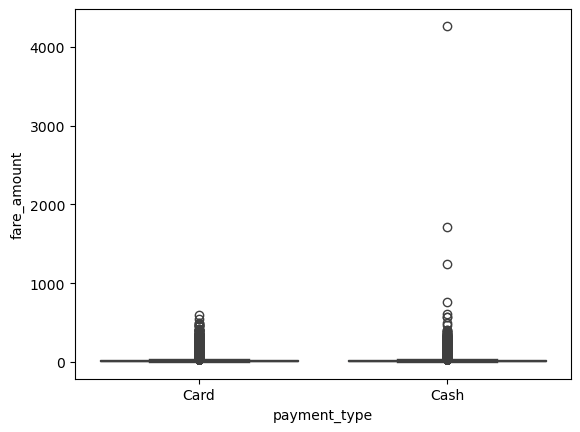

In [35]:
# check for the outliers
sns.boxplot(data=taxi_data, y="fare_amount", x="payment_type")
plt.show()

In [37]:
# removing outliers using interquartile range for the numerical variables
for col in ['trip_distance','fare_amount','duration']:
    Q1 = taxi_data[col].quantile(0.25)
    Q3 = taxi_data[col].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out outliers
    taxi_data = taxi_data[(taxi_data[col] >= lower_bound) & (taxi_data[col] <= upper_bound)]


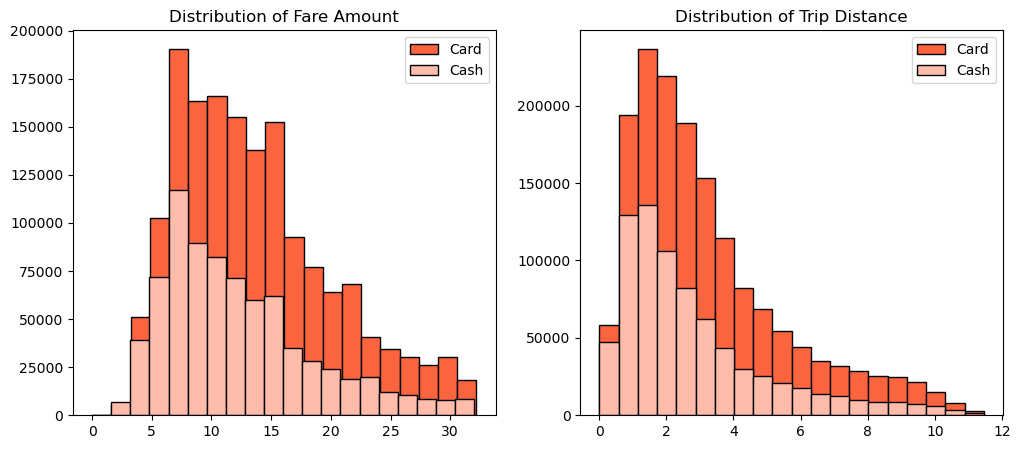

fare_amount           trip_distance          
                    mean       std          mean       std
payment_type                                              
Card           13.701903  6.506356      3.230729  2.320528
Cash           12.250209  6.246104      2.803716  2.231871

In [39]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title('Distribution of Fare Amount')
plt.hist(taxi_data[taxi_data['payment_type']=='Card']['fare_amount'], histtype='barstacked', bins = 20, edgecolor = 'k', color = '#FA643F', label = 'Card')
plt.hist(taxi_data[taxi_data['payment_type']=='Cash']['fare_amount'],  histtype='barstacked',bins = 20, edgecolor = 'k', color = '#FFBCAB',label = 'Cash')
plt.legend()

plt.subplot(1,2,2)
plt.title('Distribution of Trip Distance')
plt.hist(taxi_data[taxi_data['payment_type']=='Card']['trip_distance'], histtype='barstacked', bins = 20, edgecolor = 'k',color = '#FA643F',label = 'Card')
plt.hist(taxi_data[taxi_data['payment_type']=='Cash']['trip_distance'],  histtype='barstacked',bins = 20, edgecolor = 'k', color = '#FFBCAB',label = 'Cash')
plt.legend()
plt.show()

# calculating the mean and standard deviation group by on payment type 
taxi_data.groupby('payment_type').agg({'fare_amount': ['mean', 'std',], 'trip_distance': ['mean', 'std'],})

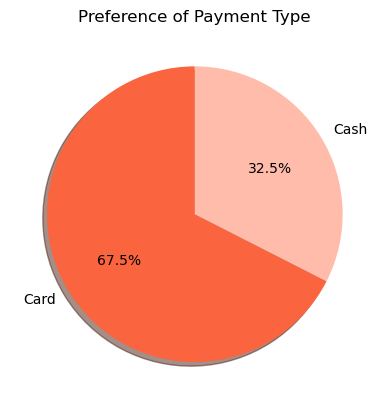

In [41]:
plt.title('Preference of Payment Type')
plt.pie(taxi_data['payment_type'].value_counts(normalize = True), labels = taxi_data['payment_type'].value_counts().index,
       startangle = 90,shadow = True, autopct = '%1.1f%%', colors = ['#FA643F','#FFBCAB'])
plt.show()

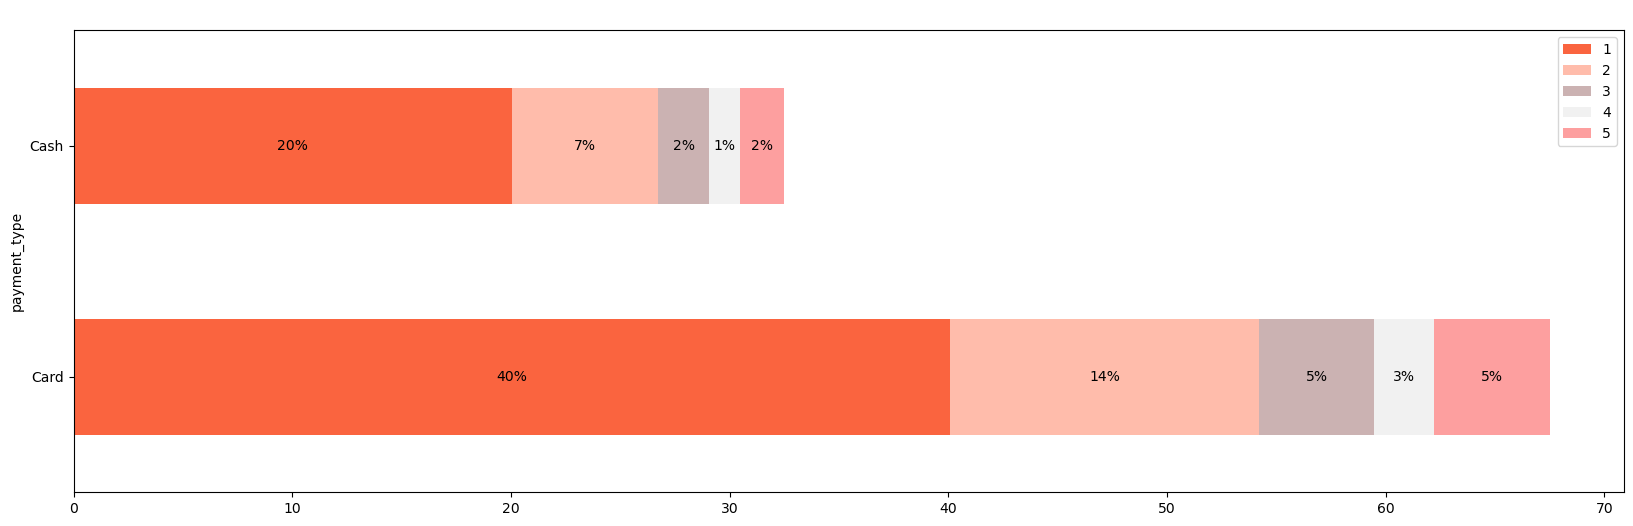

In [43]:
# calculating the total passenger count distribution based on the different payment type
passenger_count = taxi_data.groupby(['payment_type','passenger_count'])[['passenger_count']].count()

# renaming the passenger_count to count to reset the index
passenger_count.rename(columns = {'passenger_count':'count'},inplace = True)
passenger_count.reset_index(inplace = True)

# calculating the percentage of the each passenger count
passenger_count['perc'] = (passenger_count['count']/passenger_count['count'].sum())*100

# creating a new empty dataframe to store the distribution of each payment type (useful for the visualization)
df = pd.DataFrame(columns = ['payment_type',1,2,3,4,5])
df['payment_type'] = ['Card','Cash']
df.iloc[0,1:] = passenger_count.iloc[:5,-1]
df.iloc[1,1:] = passenger_count.iloc[5:,-1]

fig, ax = plt.subplots(figsize=(20, 6)) 
df.plot(x='payment_type', kind='barh', stacked=True, title=' ', ax=ax, color = ['#FA643F', '#FFBCAB', '#CBB2B2', '#F1F1F1', '#FD9F9F'] )

# Add percentage text
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
    ax.text(x + width / 2,
            y + height / 2,
            '{:.0f}%'.format(width),
            horizontalalignment='center',
            verticalalignment='center')

We are trying to get the best test possible for our data set ,. in order to do that we are using Quantile-quantile (QQ)  to assess whether the fare amount distributions for each payment type are approximately normally distributed. If the data points closely align with the diagonal line in the plot, it suggests that the data follows a normal distribution and we can use Z-Test if not we willty using other test.

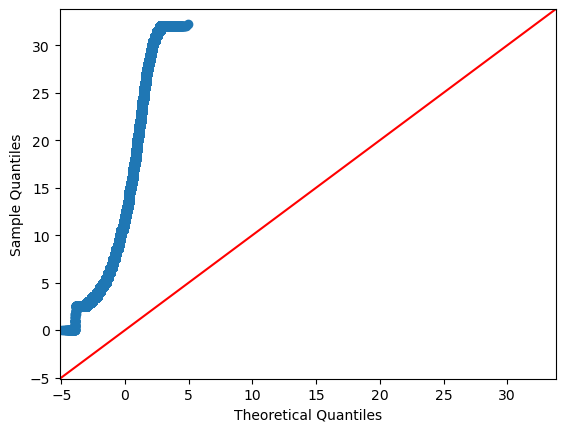

In [45]:
#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(taxi_data['fare_amount'], line='45')
plt.show()

The data values clearly do not follow the  45-degree line, which indicat that they do not follow a normal distribution. So, z-distribution will not be good for this. That's why we will use T test.

Given that the T-test can be applied to both small and large samples and does not require the population standard deviation, it is a more universally applicable approach for hypothesis testing in many practical research scenarios, including analyses of taxi trip data.


In the analysis of NYC Yellow Taxi Trip Records, where you're likely dealing with an unknown population standard deviation and potentially large datasets, the T-test offers a more appropriate and flexible method for comparing means between two groups (e.g., fare amounts by payment type). It provides a reliable way to infer about the population, accommodating the uncertainty that comes with estimating population parameters from sample data.

In [47]:
# sample 1
credit_card = taxi_data[taxi_data['payment_type'] == 'Card']['fare_amount']

# sample 2
cash = taxi_data[taxi_data['payment_type'] == 'Cash']['fare_amount']

# performing t test on both the different sample
t_stat, p_value = stats.ttest_ind(a=credit_card, b=cash, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# comparing the p value with the significance of 5% or 0.05
if p_value < 0.05:
    print("\nReject the null hypothesis")
else:
    print("\nAccept the null hypothesis")

T-statistic: 165.59915491544626, P-value: 0.0

Reject the null hypothesis
